In [1]:
%run key_imports.py
%run nn_archi.py
%run bachelier.py

In [2]:
X_df = pd.read_csv("datasets/bachelier.csv")
N_ASSETS = len([x for x in X_df.columns if x.find("asset_") == 0])
Xs = X_df.iloc[:, :N_ASSETS].values.astype(np.float32)
ys = X_df["call_payoff"].values.astype(np.float32)
grads = X_df.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)
all_res = []
X_tensor = tf.Variable(Xs)

In [3]:
"""
Model Hyperparameters
"""
HIDDEN_UNITS = 30
LAYERS = 4
HIDDEN_ACT = "softplus"
N_FEATS = Xs.shape[1]
OUTPUT_ACT = None
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
BATCH_NORM = False

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

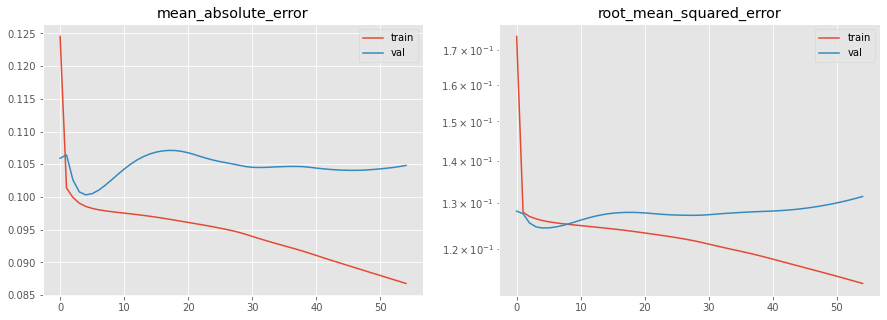

In [4]:
"""
Unconstrained NN
"""
loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError(),
]
VAL_SPLIT = 0.2
CALLBACKS = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)] + [
    EarlyStopping(patience=50)
]


opt = Adam(learning_rate=LR)
ffn = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)
intrinsic_val = (X_df["call_payoff"] > np.maximum(X_df["basket"] - 1.0, 0)) * 1
loss_weight = (intrinsic_val > 0) * 1
# loss_weight = 1.0
ffn.compile(optimizer=opt, loss=loss_fn, metrics=METRICS, loss_weights=loss_weight)
start = time.time()
history = ffn.fit(
    Xs,
    ys,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)
end = time.time()

metrics = ["mean_absolute_error", "root_mean_squared_error"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)
    ax[1].set_yscale("log")

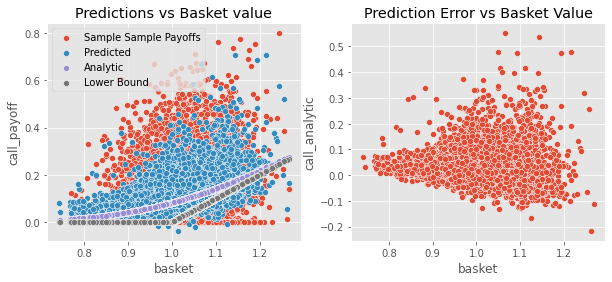

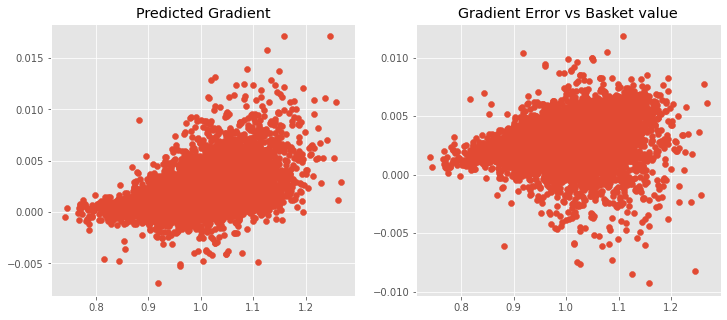

In [5]:
model = ffn

# with tf.GradientTape() as tape2:
#     with tf.GradientTape() as model_tape:
#         output = model(X_tensor)
#         model_grads = model_tape.gradient(output, X_tensor)
#     jacobian = tape2.batch_jacobian(model_grads, X_tensor)
# j_sum = tf.reduce_sum(jacobian, axis=2)
# hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
# factor_grad = tf.math.reduce_mean(model_grads, axis = 1).numpy()
# sns.scatterplot(X_df['basket'], hessian_det)

start2 = time.time()
with tf.GradientTape() as model_tape:
    output = model(X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
end2 = time.time()


preds = model.predict(Xs).reshape(-1)

temp = bachelier_eval_wrapper(
    X_df,
    X_df["call_analytic"].values,
    preds,
    factor_grad,
    lower_bound=np.maximum(X_df["basket"].values - 1.0, 0),
    upper_bound=None,
    METHOD="ffn",
)
temp["total_time"] = (end - start) + (end2 - start2)
all_res += [temp.copy()]

  0%|          | 0/100 [00:00<?, ?it/s]

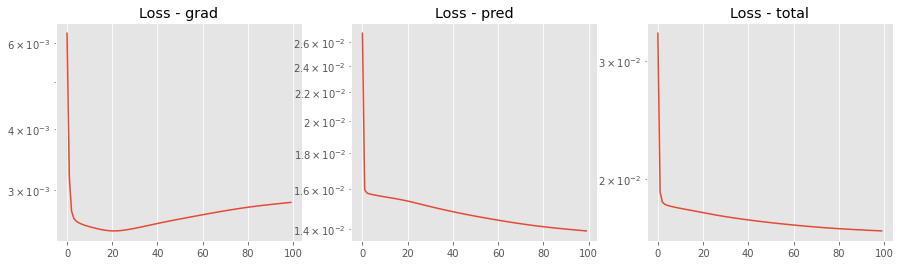

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((Xs, ys, grads))
l = 1
batched_dataset = dataset.batch(BATCH_SIZE)
losses = {"grad": [], "total": [], "pred": []}

"""
Differential
"""
# loss_fn = tf.keras.losses.MeanSquaredError()

# METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
# VAL_SPLIT = 0.2
# CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate=LR)
grad_model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)


@tf.function
def train_loop(x_batch, y_batch, grads_batch):
    with tf.GradientTape() as loss_tape:
        with tf.GradientTape() as model_tape:
            model_tape.watch(x_batch)
            output = grad_model(x_batch)
            model_grads = model_tape.gradient(output, x_batch)
        loss_weight = 1.0
        pred_loss = tf.reduce_mean(
            tf.keras.losses.MeanSquaredError()(
                output * loss_weight, y_batch * loss_weight
            )
        )
        grad_loss = tf.reduce_mean(
            tf.math.reduce_sum((grads_batch - model_grads) ** 2, axis=1) * loss_weight
        )
        total_loss = pred_loss + l * grad_loss

        loss_grad = loss_tape.gradient(total_loss, grad_model.trainable_variables)
        opt.apply_gradients(zip(loss_grad, grad_model.trainable_variables))
    return grad_loss, pred_loss, total_loss


start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_grad = []
    temp_pred = []
    temp_total = []
    for (x_batch, y_batch, grads_batch) in batched_dataset:
        # x_batch = tf.Variable(x_batch)

        grad_loss, pred_loss, total_loss = train_loop(x_batch, y_batch, grads_batch)
        temp_grad += [grad_loss.numpy()]
        temp_pred += [pred_loss.numpy()]
        temp_total += [total_loss.numpy()]

    losses["grad"] += [np.mean(temp_grad)]
    losses["pred"] += [np.mean(temp_pred)]
    losses["total"] += [np.mean(temp_total)]
end = time.time()
"""
Plot loss curves
"""
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
for i, x in enumerate(["grad", "pred", "total"]):
    ax[i].plot(losses[x])
    ax[i].set_title(f"Loss - {x}")
    ax[i].set_yscale("log")

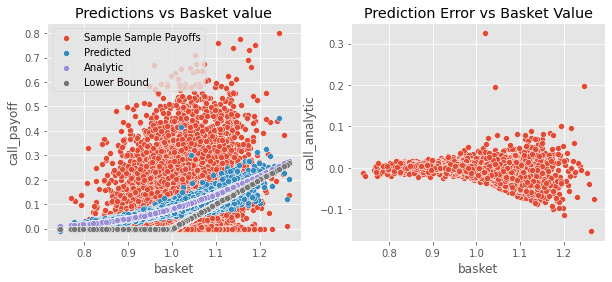

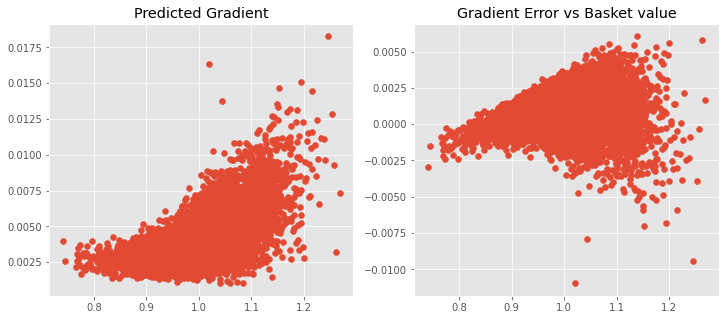

In [7]:
model = grad_model

start2 = time.time()
with tf.GradientTape() as model_tape:
    output = model(X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
end2 = time.time()


preds = model.predict(Xs).reshape(-1)

temp = bachelier_eval_wrapper(
    X_df,
    X_df["call_analytic"].values,
    preds,
    factor_grad,
    lower_bound=np.maximum(X_df["basket"].values - 1.0, 0),
    upper_bound=None,
    METHOD="differential",
)
temp["total_time"] = (end - start) + (end2 - start2)
all_res += [temp.copy()]

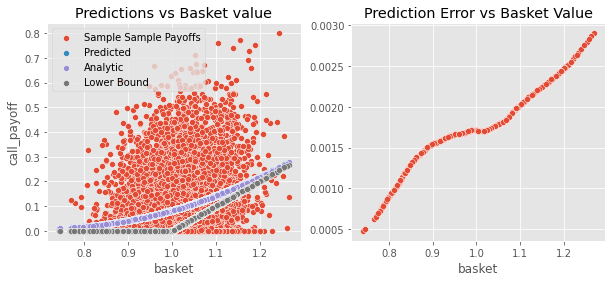

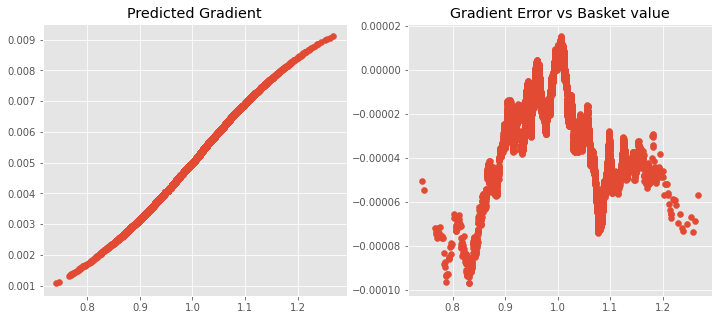

In [8]:
all_res += [
    bachelier_eval_wrapper(
        X_df,
        X_df["call_analytic_delta"],
        X_df["call_MC"],
        X_df["delta_MC"],
        lower_bound=np.maximum(X_df["basket"] - 1.0, 0),
        upper_bound=None,
        METHOD="MC",
    )
]

## res_df = pd.concat(all_res).drop_duplicates().T
res_df.loc['total_time','MC'] = 140.00
display(res_df.style.background_gradient(axis = 1))
print(res_df.style.format("{:.5f}").to_latex())

In [ ]:
"""
TODO: investigate QMC based sampling and Hessian
"""
# from numpy.linalg import cholesky
# SEED = 42
# rng = default_rng(SEED)

# """
# Define Parameters
# """
# N_ASSETS = 100
# F = N_ASSETS
# N_SAMPLES = 10 ** 4
# T = 1.0
# K = 1.0

# # Covariance matrix
# L = 0.2 * rng.standard_normal((N_ASSETS, F))
# cov = (L @ L.T)
# assert np.linalg.det(cov) > 0
# L = cholesky(cov)

# with tf.GradientTape() as tape2:
#     with tf.GradientTape() as model_tape:
#         model_tape.watch(x_batch)
#         output = grad_model(x_batch)
#         grads = model_tape.gradient(output, x_batch)
#     jacobian = tape2.batch_jacobian(grads, x_batch)

# j_sum = tf.reduce_sum(jacobian, axis=2)
# print(j_sum.shape)
# j_select = tf.einsum('bxby->bxy', jacobian)


# with tf.GradientTape() as tape2:
#     with tf.GradientTape() as model_tape:
#         output = model(X_tensor)
#         model_grads = model_tape.gradient(output, X_tensor)
#     jacobian = tape2.batch_jacobian(model_grads, X_tensor)
# j_sum = tf.reduce_sum(jacobian, axis=2)
# hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
# factor_grad = tf.math.reduce_mean(model_grads, axis = 1).numpy()
# sns.scatterplot(X_df['basket'], hessian_det)